<a href="https://colab.research.google.com/github/emilyasterjones/NMA2020-Seals-Evading-Hidden-States/blob/master/NMA_Project_Seals_Evading_Hidden_States.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuromatch Academy Team Project
**Team Members:** Emily Aery Jones, Alan Akil, Sylvie Bindas, and Roberto Lopez Cervera

**Pod:** 019 Evasive Seal

**TA:** Helen Hou

**Mentor:** Sven Bestmann

# Project Proposal
**The scientific question:** Can neural firing across multiple, task-relevant regions be described through transitions between hidden states on a trial-by-trial basis? To what extent do these states explain variance in task performance?

**Brief scientific background:** It is hypothesized that there are latent states regulating performance on perceptual decision-making tasks. Steinmetz et al, 2019 demonstrates distributed coding of a visual discrimination task across several brain regions, with prominent variation among neurons in firing rates and patterns. It is possible that this varied, distributed activity could be reconciled across brain regions by considering latent states organizing activity. 

**Dataset:** [Steinmetz et al, 2019](https://www.nature.com/articles/s41586-019-1787-x )

**Proposed analyses:** Build a Hidden Markov Model (HMM) where we propose the existence of latent states that may reflect cognitive or motivational processes. The model will be trained on spiking data from task-involved brain regions and cross-validated using held out trials. The model will output the probabilities of switching between states on a trial-by-trial basis.

**Theoretical predictions:** First, the model will confirm the presence of latent states which describe the structure of neural spiking data across multiple brain regions. Secondly, the posterior probability of each state across trials will explain some of the variance in trial accuracy.
Possible alternative outcomes: If the HMM does not accurately describe cross-validation data, then it is possible that we failed to capture all the existing latent states. Alternatively, our model (and thus the latent states) may not generalize to all brain regions, suggesting that such states are encoded uniquely in functionally defined brain regions. If the HMM posterior probability does not meaningfully map onto task performance, then it is possible that these latent states reflect some other underlying cognitive processes irrelevant to task performance after acquisition, but which could be relevant during learning.

**Controls:** Cross validate on held out neural data. Fit to shuffled spike data. Fit to no-go trials.

**What would results mean if predictions were true:** This would suggest that there are latent network states that are universal across brain regions. This would also help identify a neural signature of engagement that could account for previously unexplainable variance in behavior across trials, which could be used in future experiments to differentiate trials based on attention.

# Set up: Imports & Helper Functions

## Imports

In [ ]:
# Imports
!pip install hmmlearn
!pip install elephant

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# from HMM tutorial
import scipy.stats as ss
import pandas as pd
from hmmlearn import hmm
from matplotlib import patches

# Simulated data
import random
import seaborn as sns

# GPFA
from neo.core import SpikeTrain
import quantities as pq
from elephant.gpfa import GPFA
from matplotlib.lines import Line2D

# figure settings
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

     |████████████████████████████████| 368kB 2.7MB/s 
     |████████████████████████████████| 2.1MB 2.8MB/s 
     |████████████████████████████████| 2.1MB 19.9MB/s 
     |████████████████████████████████| 92kB 9.3MB/s 
  Created wheel for elephant: filename=elephant-0.7.0-cp36-none-any.whl size=724075 sha256=e170b3edcdc54db803decac2d013466981fa115b5ca3e1fa73cfb66d0517f45d
  Stored in directory: /root/.cache/pip/wheels/62/54/12/dacee4cfc469de0703e58074c2d6138e08836e7cf1782cbce8
  Created wheel for neo: filename=neo-0.8.0-cp36-none-any.whl size=558935 sha256=35d613ce1f81324951e627a4f48ec1bb15e74a8df13bad05de8572de6f114c55
  Stored in directory: /root/.cache/pip/wheels/28/35/f4/273432a8b9eb6c9182e666e9630cc92c221dabe81462606d9c
  Created wheel for quantities: filename=quantities-0.12.4-cp36-none-any.whl size=79167 sha256=486b3e75846e71b0d23932827b2a8a52b0b3307afd003cd4cf0781e8b66ecb42
  Stored in directory: /root/.cache/pip/wheels/2c/27/a5/62fb2a57d167d7b7164278de7399ba1504321c1d6c3a3802

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/elephant/pandas_bridge.py:22: DeprecationWarning: pandas_bridge module will be removed in Elephant v0.8.x
  DeprecationWarning)


## Visualization Functions

In [ ]:
# For firing rates
def plot_firing_rates(time, fr, linewidth=None):
  """Plots firing rates over specified time range.

  Args:
    time (numpy array of float):          Starts of timebins.
    fr (numpy array of floats):           Firing rates in each timebin.
    linewidth (float):                    Linewidth (optional).
  """

  sns.set()
  sns.set_style('whitegrid')
  sns.set_style('white')
  sns.set_style("ticks")
  sns.set_context("talk", font_scale=1.9, rc={"lines.linewidth":3.3}) 
  if len(np.nonzero(linewidth)) == 0:
    plt.plot(time, fr)
  elif len(np.nonzero(linewidth)) != 0:
    plt.plot(time, fr, linewidth=linewidth)
  sns.despine()
  plt.ylabel('rate (Hz)')
  plt.xlabel('time (ms)')
  return
  
# For spike rasters
def plot_raster_function(spike_times, spike_indices, markersize):
  """Plot raster of the whole experiment.

  Args:
    spike_times (numpy array of float):   Spike times (ms).
    spike_indices (numpy array of ints):  Array index of each spike.
    markersize (float):                   Marker size.
  """
  # Input spike times in ms, but we plot them in seconds.
  sns.set()
  sns.set_style('whitegrid')
  sns.set_style('white')
  sns.set_style("ticks")
  sns.set_context("talk", font_scale=1.9, rc={"lines.linewidth":3.3}) 
  plt.plot(spike_times/1000,spike_indices+1,'k.',markersize=markersize)
  plt.xlim((0,np.max(spike_times)/1000))
  plt.ylim((0,np.max(spike_indices)))
  plt.yticks((1,np.max(spike_indices)+1))
  plt.xticks((0,np.max(spike_times)/1000))
  plt.xlabel('Time (s)')
  plt.ylabel('Neuron')

# For dimensionality reduction
# From tutorials
def plot_variance_explained(variance_explained):
  """Plots eigenvalues.

  Args:
    variance_explained (numpy array of floats) : Vector of variance explained
                                                 for each PC
  """
  fig=plt.figure(figsize=(8,5))
  plt.plot(np.arange(1, len(variance_explained) + 1), variance_explained,
           '--k')
  plt.xlabel('Number of components')
  plt.ylabel('Variance explained')
  plt.show()


def plot_eigenvalues(evals):
  """Plots eigenvalues.

  Args:
     (numpy array of floats) : Vector of eigenvalues
  """
  fig=plt.figure(figsize=(8,5))
  plt.plot(np.arange(1, len(evals) + 1), evals, 'o-k')
  plt.xlabel('Component')
  plt.ylabel('Eigenvalue')
  plt.title('Scree plot')
  plt.show()

#For HMM
def plot_states(real_states, states, obs_label, title):
  """Plots HMM states and observations for 1d states and observations.

  Args:
    real_states (numpy array of floats):  Observed or simulated states.
    states (numpy array of floats):       HMM latent states.
    obs_label (string):                   Observed/simulated state label.
    title (string):                       Plot title.
  """
  plt.plot(real_states, label=obs_label, c="blue")
  plt.plot(states, "--", label="Latent States", c="orange")
  plt.yticks(ticks=[0,1], labels=['Incorrect','Correct'])
  plt.xlabel("Trials")
  plt.ylabel("State")
  plt.title("Simulated correct/incorrect trials")
  leg = plt.legend(bbox_to_anchor=(1.04,1), loc="upper left",frameon='none',markerscale=1)
  leg.get_frame().set_linewidth(0.0)

#RLC update
# Add trial start markers and state-dependent color coding

def trial_marker(trial_start_idx):
  """Creates vertical lines marking the start of each trial.

  Args:
    trial_start_idx (numpy array of floats):  Index of trial start times
  """

  for tr in trial_start_idx:
    plt.axvline(x=tr, color= 'r', lw= 1.8)

def state_colors(states):
  """Color codes different states in HMM.

  Args: 
    states ():
  """
  
  state_change = np.diff(states)
  sc_idx = np.argwhere(state_change > 1)
  last_tr = 0
  for i in sc_idx:
    c= states[i + 1] + 2 # try different integers for different color schemes
    if last_tr == 0:
      rect = patches.Rectangle((last_tr, 0), i, '[insert height]', facecolor=plt.get_cmap('tab10').colors[c],
                                  alpha=0.15)
      last_tr = i
    else:
      rect = patches.Rectangle((last_tr, 0), i, '[insert height]', facecolor=plt.get_cmap('tab10').colors[c],
                                  alpha=0.15)
      last_tr = i

    plt.gca().add_patch(rect)

  

## Data processing functions

In [ ]:
# Convert [neuron_id, spiketime] format to neurons x spike count format
def bin_spikes(neuron_ids, spike_train, end_time, bin):
  """Converts spike timestamps into binned spike counts & smoothed firing rates
        
      Args:
        neuron_ids (numpy array of ints):     ID of the neuron of each spike.
        spike_train (numpy array of floats):  Spike timestamps.
        end_time (float):                     End timestamp of spike traces.
        bin (int):                            Bin size (ms).

      Returns:
        spike_counts (numpy array of ints):   Spike counts per bin (neurons, spikes).
        firing_rates (numpy array of floats): Firing rates in each bin (neurons, rates).
    """
  Num_neurons = (np.max(neuron_ids) + 1).astype(int)
  timeVector = np.arange(0,end_time,bin)
  spike_counts = np.zeros((Num_neurons,len(timeVector)-1))

  # Counts spikes in bins of [bin] ms.
  for i in range(Num_neurons):
    hist, bin_edges = np.histogram(spike_train[neuron_ids==i],bins = timeVector) 
    spike_counts[i,:] = hist 
  RateT = spike_counts / bin *1000 #convert to Hz

  # Slide a moving average window over the rates to smooth.
  Num_points = np.int(len(RateT[0]))
  firing_rates = np.zeros((Num_neurons,Num_points))
  # Smooth the rate of each neuron separately.
  for j in range(Num_neurons):  
    firing_rates[j,:] = np.convolve(RateT[j], np.ones((window,))/window, mode='same')

  return spike_counts, firing_rates

# Spike traces for HMM
def trace_to_trials_function(firing_rate, TrialTime, dtRate, Num_trials):
  """Transform the trace of the whole experiment into a matrix with rows=samples, cols=trials

  Args:
    firing_rate (numpy array of float):   Firing rates over entire trace.
    TrialTime (float):                    Length of trial (ms).
    dtRate (int):                         Bin size (ms).
    Num_trials (int):                     # of trials.

  Returns:
    fr_trials (numpy array of float):     Firing rates parcellated by trial.
  """

  # Divide trial time by bin size to get number of samples in a trial.
  fr_trials = np.zeros((TrialTime//dtRate,Num_trials)) 
  for trial in range(Num_trials):
      trial_start = TrialTime//dtRate * trial
      trial_end = TrialTime//dtRate * (trial+1)
      fr_trials[:,trial] = firing_rate[trial_start:trial_end]
  return fr_trials

# HMM accuracy
def get_accuracy(real_states, states):
  """Matches state assignments & calculates percent accuracy

  Args:
    real_states (numpy array of floats):  Observed or simulated states.
    states (numpy array of floats):       HMM latent states.

  Returns:
    per_correct (float):                  % accuracy of classification.
    states (numpy array of floats):       States, inverted if necessary.
  """
  per_correct = (1 - np.sum(np.abs(real_states-states))/len(states))*100
  if per_correct < 50:
    per_correct = 100-per_correct
    states = 1-states
  return per_correct, states

# GPFA
def build_spike_train(dat):
  ''' build (trials x neurons) structure of SpikeTrain objects
      Args:
        dat (ndarray of float):               (neuron IDs, timestamps, trial start time, trial end time)

      Returns:
        spike_times (ndarray of SpikeTimes):  trial x neuron SpikeTimes structure
        correct (ndarray of int):             0 (incorrect) or 1 (correct) per trial
  '''
  trial_starts = sorted(set(dat[:,2]))
  trial_ends = sorted(set(dat[:,3]))
  neurons = sorted(set(dat[:,0]))
  spike_times = []
  correct = []
  for t, (t_start, t_end) in enumerate(zip(trial_starts, trial_ends)):
    spike_times_per_trial = []
    trial = np.where(dat[:,2]==t_start)
    correct.append(int(dat[trial[0][0],4]))
    for n, neuron in enumerate(neurons):
      subset = (dat[:,0]==neuron) & (dat[:,2]==t_start)
      spike_times_per_trial.append(SpikeTrain(dat[subset,1]*pq.s, t_start=t_start, t_stop=t_end))
    spike_times.append(spike_times_per_trial)
  
  return spike_times, correct

# Define functions for simulation of Poisson network

In [ ]:
# Simulate uncorrelated data for testing our model with low and high firing rates.
def simulate_trials_different_rates(Num_neurons, Num_trials, Fraction_of_correct_trials, 
                    rate_baseline, rate_elevated, TrialTime, dtRate, window):
  """Transform the trace of the whole experiment into a matrix with rows=samples, cols=trials

  Args:
    Num_neurons (int):                    # neurons to simulate
    Num_trials (int):                     # trials
    Fraction_of_correct_trials (float):   fraction incorrect (between 0 and 1)
    rate_baseline (float):                firing rate (Hz)
    rate_elevated (float):                firing rate during correct trials (Hz)
    TrialTime (int):                      average trial length (ms)
    dtRate (int):                         firing rate bin (ms)
    window (int):                         smoothing window (ms)

  Returns:
    spike_train (numpy array of floats):  Poisson spike train across all time,
                                            size (neurons, time in ms)
  """

  Num_correct_trials = int(np.floor(Fraction_of_correct_trials * Num_trials))
  # Generate Poisson spike trains if neurons are uncorrelated.
  # Randomly interleave correct and incorrect trials.
  trials_correct = np.sort(np.random.choice(Num_trials, size=Num_correct_trials, replace=False))
  trials_wrong = np.setdiff1d(np.arange(0,Num_trials,step=1),trials_correct)

  # Preallocate memory for the spike train of the whole experiment.
  spike_train = np.zeros((int(Num_neurons*rate_elevated*TrialTime*Num_trials*2),4))
  temp = 0 # This is just use to facilitate saving of spikes given that they vary in number at each trial.
  # Loop over trials and generate uncorrelated spikes for each neuron in each trial.
  for trial in range(Num_trials):
    # If the trial is correct.
    if trial in trials_correct: # Do correct and wrong trials separately.
      time_start_trial = TrialTime*trial
      time_end_trial = TrialTime*(trial+1)
      if trial == 0:
        temp = 0
      else:
        temp += len(sx[0]) # Use previous one to know where to save spikes.
      # Generate a random number of spikes for all neurons over the trial.
      Num_spike=np.random.poisson(Num_neurons*rate_elevated*TrialTime)
      # Spread the spikes over neurons and time.
      st=np.random.uniform(low=time_start_trial,high=time_end_trial,size=(Num_spike,1))
      sx=np.zeros((2,len(st))) 
      sx[0]=np.sort(st)[:,0] # Spike times
      sx[1]=np.random.choice(Num_neurons,size=len(st)) # Neuron indices
      # Save the spike train
      spike_train[temp:temp+len(sx[0]),0] = sx[1] # Neuron indices
      spike_train[temp:temp+len(sx[1]),1] = sx[0] # Spike times
      spike_train[temp:temp+len(sx[0]),2] = time_start_trial*np.ones((1,len(sx[0])))[0] # Trial start times
      spike_train[temp:temp+len(sx[1]),3] = time_end_trial*np.ones((1,len(sx[0])))[0] # Trial end times
    else: # If the trial is incorrect.
      time_start_trial = TrialTime*trial
      time_end_trial = TrialTime*(trial+1)
      if trial == 0:
        temp = 0
      else:
        temp += len(sx[0]) # Use previous one to know where to save spikes.
      # Generate a random number of total spikes.
      Num_spike=np.random.poisson(Num_neurons*rate_baseline*TrialTime)
      # Spread them over time.
      st=np.random.uniform(low=time_start_trial,high=time_end_trial,size=(Num_spike,1))
      sx=np.zeros((2,len(st)))
      sx[0]=np.sort(st)[:,0] # Sort by time.
      sx[1]=np.random.choice(Num_neurons,size=len(st)) # neuron indices
      # Save the spike train
      spike_train[temp:temp+len(sx[0]),0] = sx[1] # Neuron indices
      spike_train[temp:temp+len(sx[1]),1] = sx[0] # Spike times
      spike_train[temp:temp+len(sx[0]),2] = time_start_trial*np.ones((1,len(sx[0])))[0] # Trial start times
      spike_train[temp:temp+len(sx[1]),3] = time_end_trial*np.ones((1,len(sx[0])))[0] # Trial end times      
  # Get rid of padded zeros (because we didn't know a priori what the total # of spikes was going to be).
  spike_train = spike_train[np.where(spike_train[:,0]!=0)]
  spike_train[np.argsort(spike_train[:, 0])] # Sort spike train by spike times.

  spike_counts, firing_rates = bin_spikes(spike_train[:,0], spike_train[:,1], 
                                          TrialTime*Num_trials+dtRate, dtRate)
  
  return spike_train, firing_rates, trials_correct, spike_counts

# This code block generates correlated Poisson spike trains.
# In correct trials, neurons are more correlated. While in wrong trials neurons have low correlations.
def simulate_trials_different_corrs(Num_neurons, Num_trials, Fraction_of_correct_trials, rate_baseline, 
                    taujitter,c_baseline, c_elevated, TrialTime, dtRate, window):
  """Transform the trace of the whole experiment into a matrix with rows=samples, cols=trials

  Args:
    Num_neurons (int):                    # neurons to simulate
    Num_trials (int):                     # trials
    Fraction_of_correct_trials (float):   fraction incorrect (between 0 and 1)
    rate_baseline (float):                firing rate (Hz) - constant across trials
    taujitter (float):                    Mean jittering of spike timing (ms). This is used to avoid perfect synchrony.
    c_baseline (float):                   pairwise correlations during incorrect trials (dimensionless)
    c_elevated (float):                   pairwise correlations during correct trials (dimensionless)
    TrialTime (int):                      average trial length (ms)
    dtRate (int):                         firing rate bin (ms)
    window (int):                         smoothing window (ms)

  Returns:
    spike_train (numpy array of floats):  Poisson spike train across all time,
                                            size (neurons, time in ms)
  """

  Num_correct_trials = int(np.floor(Fraction_of_correct_trials * Num_trials))
  # Generate Poisson spike trains if neurons are uncorrelated.
  # Randomly interleave correct and incorrect trials.
  trials_correct = np.sort(np.random.choice(Num_trials, size=Num_correct_trials, replace=False))
  trials_wrong = np.setdiff1d(np.arange(0,Num_trials,step=1),trials_correct)
  # Preallocate memory for the spike train of the whole experiment.
  spike_train = np.zeros((int(Num_neurons*rate_elevated*TrialTime*Num_trials*2),4))
  temp = 0 # This is just use to facilitate saving of spikes given that they vary in number at each trial.
  # Loop over trials to generate spike trains for all neurons in each trial.
  for trial in range(Num_trials):
    if trial in trials_correct: # If trial is correct.
      rm=rate_baseline/c_elevated # Firing rate of mother process.
      # Define the beginning and end of trial.
      time_start_trial = TrialTime*trial
      time_end_trial = TrialTime*(trial+1)
      if trial == 0:
        temp = 0
      else:
        temp += len(sx[0]) # Use previous one to know where to save spikes.
      # Define a mother process to generate correlated Poisson spikes.
      Num_spike_moth=np.random.poisson(rm*TrialTime); # Number of mother spikes
      stm=np.random.uniform(low=time_start_trial,high=time_end_trial,size=(Num_spike_moth,1))
      maxnsx=int(TrialTime*rate_baseline*Num_neurons*2); # Max num spikes
      sx=np.zeros((2,maxnsx)) 
      ns=0
      # Loop over each neuron to generate its spike train in each trial.
      for j in range(Num_neurons):
        ns0 = np.random.binomial(Num_spike_moth,c_elevated)
        st=random.sample(list(stm[:,0]),ns0) # Sample spike times randomly
        st=st+taujitter*np.random.normal(0,1,size=len(st)) # jitter spike times
        st=st[(st>time_start_trial) & (st<time_end_trial)] # Get rid of out-of-bounds times
        ns0=len(st) # Re-compute spike count
        sx[0,ns:ns+ns0]=st # Set the spike times and indices        
        sx[1,ns:ns+ns0]=j
        ns=ns+ns0
      # Get rid of padded zeros, since we didn't initially know how many spikes there would be.
      sx = sx[:,sx[0,:]>0]
      # Sort by spike time
      I = np.argsort(sx[0,:])
      sx = sx[:,I]
      nspikeX=len(sx[0,:])
      # Save spike times and indices.
      # spike_train[temp:temp+len(sx[0]),0] = sx[0] # Spike times
      # spike_train[temp:temp+len(sx[1]),1] = sx[1] # Neuron indices
      spike_train[temp:temp+len(sx[0]),0] = sx[1] # Neuron indices
      spike_train[temp:temp+len(sx[1]),1] = sx[0] # Spike times
      spike_train[temp:temp+len(sx[0]),2] = time_start_trial*np.ones((1,len(sx[0])))[0] # Trial start times
      spike_train[temp:temp+len(sx[1]),3] = time_end_trial*np.ones((1,len(sx[0])))[0] # Trial end times 
    else:
      # if trial is wrong.
      rm=rate_baseline/c_baseline # Firing rate of mother process
      # Define the beginning and end of trial.
      time_start_trial = TrialTime*trial
      time_end_trial = TrialTime*(trial+1)
      if trial == 0:
        temp = 0
      else:
        temp += len(sx[0]) # Use previous one to know where to save spikes.
      # If correct trial.
      # If correlated
      Num_spike_moth=np.random.poisson(rm*TrialTime); # Number of mother spikes
      stm=np.random.uniform(low=time_start_trial,high=time_end_trial,size=(Num_spike_moth,1))
      maxnsx=int(TrialTime*rate_baseline*Num_neurons*2) # Max num spikes
      sx=np.zeros((2,maxnsx)) 
      ns=0
      # Loop over each neuron to generate its spike train in each trial.
      for j in range(Num_neurons):
        ns0 = np.random.binomial(Num_spike_moth,c_baseline)
        st=random.sample(list(stm[:,0]),ns0) # Sample spike times randomly
        st=st+taujitter*np.random.normal(0,1,size=len(st)) # jitter spike times
        st=st[(st>time_start_trial) & (st<time_end_trial)] # Get rid of out-of-bounds times
        ns0=len(st) # Re-compute spike count
        sx[0,ns:ns+ns0]=st # Set the spike times        
        sx[1,ns:ns+ns0]=j # Neuron index
        ns=ns+ns0
      # Get rid of padded zeros
      sx = sx[:,sx[0,:]>0]
      # Sort by spike time
      I = np.argsort(sx[0,:])
      sx = sx[:,I]
      nspikeX=len(sx[0,:])
      # Save spike times and indices.
      # spike_train[temp:temp+len(sx[0]),0] = sx[0] # Spike times
      # spike_train[temp:temp+len(sx[1]),1] = sx[1] # Neuron indices
      spike_train[temp:temp+len(sx[0]),0] = sx[1] # Neuron indices
      spike_train[temp:temp+len(sx[1]),1] = sx[0] # Spike times
      spike_train[temp:temp+len(sx[0]),2] = time_start_trial*np.ones((1,len(sx[0])))[0] # Trial start times
      spike_train[temp:temp+len(sx[1]),3] = time_end_trial*np.ones((1,len(sx[0])))[0] # Trial end times 
  # Get rid of padded zeros.
  spike_train = spike_train[np.where(spike_train[:,0]!=0)]
  spike_train[np.argsort(spike_train[:, 0])]
  # Count spikes in bins of size dtRate milliseconds.
  timeVector = np.arange(0,TrialTime*Num_trials+dtRate,dtRate) 
  spike_counts = np.zeros((Num_neurons,len(timeVector)-1))
  for i in range(Num_neurons):
    hist, bin_edges = np.histogram(spike_train[spike_train[:,1]==i,0]
                    ,bins = timeVector) 
    spike_counts[i,:] = hist 
  RateT = spike_counts / dtRate *1000 # Multiply by 1000 to turn kHz into Hz.
  # Slide a moving average window over the rates to smooth them more if necessary.
  Num_points = np.int(len(RateT[0]))
  firing_rates = np.zeros((Num_neurons,Num_points))
  # Smooth the rate of each neuron separately.
  for j in range(Num_neurons):  
    firing_rates[j,:] = np.convolve(RateT[j], np.ones((window,))/window, mode='same')
  return spike_train, firing_rates, trials_correct, spike_counts

# Load & examine data

## Load data from Steinmetz et al, 2019

First import .tar archives files and extract into dictionaries:

In [ ]:
# def mylistdir(directory):
#     """A specialized version of os.listdir() that ignores files that
#     start with a leading period."""
#     filelist = os.listdir(directory)
#     return [x for x in filelist
#             if not (x.startswith('.'))]

# # filepath here should be wherever you have allData (8GB folder of downloaded data) saved
# folder = 'your/filepath/here'
# n_sessions = len(os.listdir(folder))

# for f in mylistdir(folder):
#     # creating a new folder to save this session's extracted folder
#     new_folder = os.path.join('your/filepath/here', f'{f}_extracted')
#     new_path = f'your/filepath/here/{f}'
#     if new_path.endswith('.tar'):
#         if os.path.isfile(new_path)==True:
#             # print('good 2 go')
#             tar = tarfile.open(new_path, "r:")
#             ## put your filepath that you want to extract to here!! 
#             tar.extractall(f'{new_folder}')
#             tar.close()          
#     else:
#         # print(f'{f} is a directory, can not unzip')
#         continue  

# ## loading pickle files you have saved
# # wherever you have your pickles saved to 
# os.chdir('/your/filepath/here')
         
# name_of_vars = ['spike_clusters', 'spikes_times', 'channel_brainLocations', 'clusters_phy_annotation',
#                'clusters_peakChannel', 'trial_intervals', 'goCue_times', 'feedback_types', 'feedback_times',
#                'response_choices', 'response_times', 'stimContrast_left', 'stimContrast_right', 'stim_times',
#                'eye_area', 'eye_times', 'face_energy', 'face_times']

# spike_clusters = np.load('spike_clusters.npy', allow_pickle=True)
# spikes_times = np.load('spikes_times.npy', allow_pickle=True)

# channel_brainLocations = np.load('channel_brainLocations.npy', allow_pickle=True)
# clusters_phy_annotation = np.load('clusters_phy_annotation.npy', allow_pickle=True)
# clusters_peakChannel = np.load('clusters_peakChannel.npy', allow_pickle=True)

# trial_intervals = np.load('trial_intervals.npy', allow_pickle=True)
# goCue_times = np.load('goCue_times.npy', allow_pickle=True)
# feedback_types = np.load('feedback_types.npy', allow_pickle=True)
# feedback_times = np.load('feedback_times.npy', allow_pickle=True)
# response_choices = np.load('response_choices.npy', allow_pickle=True)
# response_times = np.load('response_times.npy', allow_pickle=True)
# stimContrast_left = np.load('stimContrast_left.npy', allow_pickle=True)
# stimContrast_right = np.load('stimContrast_right.npy', allow_pickle=True)
# stim_times = np.load('stim_times.npy', allow_pickle=True)
# eye_area = np.load('eye_area.npy', allow_pickle=True)
# eye_times = np.load('eye_times.npy', allow_pickle=True)
# face_energy = np.load('face_energy.npy', allow_pickle=True)
# face_times = np.load('face_times.npy', allow_pickle=True)
         
# print('all files loaded in!')

Next, extract only the data from the primary visual cortex:

In [ ]:
# vis_ctx = {}
# sessions = np.arange(1, 41)

# for s in sessions:
#     print('session:', s)
#     # find which channels are in V1
#     rows = np.shape(channel_brainLocations[s])[0] # how many channels in this session
#     channels = [] 
#     for r in range(rows):
#         if channel_brainLocations[s][r]=='VISp': # this string can be modified to find data for any region
#             channels.append(r)
#         else:
#             continue
#     if len(channels)<1:
#         print('this session had no recordings in ROI')
#         continue
#     channels = np.asarray(channels)
    
#     # now find all clusters who's peak value was at this channel
#     clusters = []
#     for chan in channels:
#         more_rows = np.shape(clusters_peakChannel[s])[0] # how many clusters in this session
#         for r2 in range(more_rows):
#             if int(np.squeeze(clusters_peakChannel[s][r2])) == chan and int(np.squeeze(clusters_phy_annotation[s][r2])) == 2:
#                 clusters.append(r2)
#             else:
#                 continue
#         else:
#             continue
#     #print(clusters)
#     clusters = np.asarray(clusters)
    
#     # now find all spikes who were included in this cluster
#     spikes = []
#     for clus in clusters:
#         print('cluster', clus, 'of', len(clusters))
#         most_rows = np.shape(spikes_clusters[s])[0] # how many spikes in this session
#         for r3 in range(most_rows):
#             if int(np.squeeze(spikes_clusters[s][r3])) == clus:
#                 spikes.append(r3)
                
#     spikes = np.asarray(spikes)
#     print(spikes)
#     vis_ctx[s]=spikes

Accompanying dictionaries for V1 neuron timestamps & clusters:

In [ ]:
# os.chdir('filepath/here')
# vis_ctx = np.load("V1_spikes.npy", allow_pickle=True)
# spikes_times = np.load('spikes_times.npy', allow_pickle=True)

# # initialize dictionary with the same keys as vis_ctx
# vis_timestamps = {}
# keyList = vis_ctx.keys()
# for i in keyList: 
#     vis_timestamps[i] = None
    
# for (keyTS, valueTS) in vis_timestamps.items():
#     print('session', keyTS)
#     spike_indices = vis_ctx[keyTS]
#     spiketimes = []
#     for key, value in vis_ctx.items():
#         for v in value:  
#             spiketime = spikes_times[key][v]
#             spiketimes.append(spiketime)
#         vis_timestamps[key] = np.asarray(spiketimes)

# spikes_clusters = np.load('spikes_clusters.npy', allow_pickle=True)

# # initialize another dictionary with the same keys as vis_ctx
# vis_clusters = {}
# keyList = vis_ctx.keys()
# for i in keyList: 
#     vis_clusters[i] = None
    
# for (keyC, valueC) in vis_clusters.items():
#     print('session', keyC)
#     spike_indices = vis_ctx[keyC]
#     spike_clusters = []
#     for key, value in vis_ctx.items():
#         for v in value:  
#             spikeclus = spikes_clusters[key][v]
#             spike_clusters.append(spikeclus)
#         vis_clusters[key] = np.asarray(spike_clusters)

## Calculate descriptive statistics for simulated data
We first want to make sure our model works with simulated data. We start by calculating relevant variables from the real data - average firing rate, trial length, and percent correct - so we can simulate to match these values.

In [ ]:
# # ## get trial types (contra/ipsi/nogo) for a given session
# # ## calculate percent correct for each session

# perc_corr = np.zeros(40)
# sessions = vis_ctx.keys()
# trial_type = {new_key: [] for new_key in sessions}

# contra_clusters = []
# contra_spiketimes = []
# contra_starts = []
# contra_ends = []
# contra_beh = []
# contra_session = []

# ipsi_clusters = []
# ipsi_spiketimes = []
# ipsi_starts = []
# ipsi_ends = []
# ipsi_beh = []
# ipsi_session = []

# nogo_clusters = []
# nogo_spiketimes = []
# nogo_starts = []
# nogo_ends = []

# for s in sessions:
#     print('session', s, 'has length', len(vis_timestamps[s]))
#     trials = len(goCue_times[s]) # nTrials
    
#     for t in range(trials):
        
#         response = int(response_choices[s][t]) # -1 right, 0 nogo, 1 left
#         feedback = int(feedback_types[s][t]) # -1 incorrect, 1 correct
#         lowerT = stim_times[s][t]
#         upperT = goCue_times[s][t]
        
#         this_trial_spikes = []
#         this_cluster = []
#         trial_start = []
#         trial_end = []
#         sesh = []
        
#         for i in np.arange(1, len(vis_timestamps[s])):
#             value = vis_timestamps[s][i]
#             if lowerT <= value < upperT: 
#                 this_trial_spikes.append(float(vis_timestamps[s][i]))
#                 this_cluster.append(int((vis_clusters[s][i])))
#                 trial_start.append(lowerT)
#                 trial_end.append(upperT)
#                 sesh.append(s)  

#         if response == 1: ## if this was a contralateral trial
#             contra_spiketimes.extend(this_trial_spikes)
#             contra_clusters.extend(this_cluster)
#             contra_starts.extend(trial_start)
#             contra_ends.extend(trial_end)
#             contra_session.extend(sesh)
#             spikes_in_trial = int(len(this_trial_spikes))
#             if feedback == 1:
#                 contra_beh.extend([1]*spikes_in_trial)
#             elif feedback == -1:
#                 contra_beh.extend([0]*spikes_in_trial)

#         elif response == -1: ## if this was an ipsilateral trial
#             ipsi_spiketimes.extend(this_trial_spikes)
#             ipsi_clusters.extend(this_cluster)
#             ipsi_starts.extend(trial_start)
#             ipsi_ends.extend(trial_end)
#             ipsi_session.extend(sesh)
#             spikes_in_trial = int(len(this_trial_spikes))
#             if feedback == 1:
#                 ipsi_beh.extend([1]*spikes_in_trial)
#             elif feedback == -1:
#                 ipsi_beh.extend([0]*spikes_in_trial)

#         elif response == 0: ## if this was a nogo trial
#             nogo_spiketimes.extend(this_trial_spikes)
#             nogo_clusters.extend(this_cluster)
#             nogo_starts.extend(trial_start)
#             nogo_ends.extend(trial_end)
            
# print('done!')
            
# contra_dict = {'n_neuron':contra_clusters, 'spiketimes':contra_spiketimes, 'starts': contra_starts, 'ends': contra_ends, 'behavior': contra_beh, 'session': contra_session}
# ipsi_dict = {'n_neuron':ipsi_clusters, 'spiketimes':ipsi_spiketimes, 'starts': ipsi_starts, 'ends': ipsi_ends, 'behavior': ipsi_beh, 'session': ipsi_session}
# nogo_dict = {'n_neuron':nogo_clusters, 'spiketimes':nogo_spiketimes, 'starts': nogo_starts, 'ends': nogo_ends}

# os.chdir('/where/to/save')

# file_to_write = open("contra_dict.npy", "wb")
# pickle.dump(contra_dict, file_to_write)

# file_to_write = open("ipsi_dict.npy", "wb")
# pickle.dump(ipsi_dict, file_to_write)

# file_to_write = open("nogo_dict.npy", "wb")
# pickle.dump(nogo_dict, file_to_write)

In [ ]:
# ## average time window and % correct
# print('avg time window:', np.mean(time_window))
# print('avg % correct trials:', np.mean(perc_corr))

# Build HMM & test using simulated data
Next, we simulate Poisson spike trains with the same mean firing rate as the real data. We calculate the firing rate in 10ms bins. We bin this into trials that match the mean trial length of the real data, then randomly label 74% of them as correct trials, then alter the binned spike trains of the correct trials to add some structure which we will try to uncover with our HMM.

## Simulate data

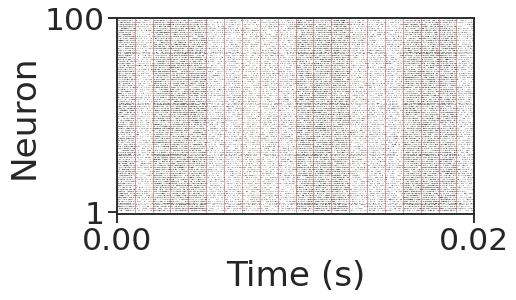

In [ ]:
# Specify the parameters for our simulated data
Num_neurons = 100
Num_trials = 20

# placeholders until V1 data is available
perc_corr = 0.5
firingRate = 20/1000 # kHz
rate_elevated = 40/1000 # kHz
time_to_onset = 1000 # Time of each trial in ms. This is variable so we can add a random variable to jitter it.
dtRate = 10 # ms (bin size)
window = 10 #ms bin size of moving window.

spike_train, firing_rates, trials_correct, spike_counts = simulate_trials_different_rates(Num_neurons, 
                                                                                          Num_trials, perc_corr, firingRate, 
                                                                                          rate_elevated, time_to_onset, 
                                                                                          dtRate, window)
spike_train[:,1:] = spike_train[:,1:]/1000
# Plot all neurons over the whole simulated experiment.
fig=plt.figure(figsize=(8,5))
ax = plt.subplot(111)
plot_raster_function(spike_train[:,1],spike_train[:,0],markersize=.1)

for tr in range(0,20):
    plt.axvline(x=tr/1000, color= 'r', lw= 0.5)


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:47: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
  result = getattr(asarray(obj), method)(*args, **kwds)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:47: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
  result = getattr(asarray(obj), method)(*args, **kwds)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:47: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
  result = getattr(asarray(obj), method)(*args, **kwds)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:47: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surp

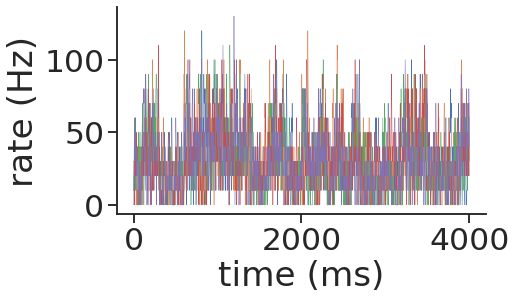

In [ ]:
## Visualize firing rates.
# We have simulated the spike trains with varying firing rates on different trials.
# Now we use them to compute the firing rate of each neuron.
# Start the figure.
fig=plt.figure(figsize=(8,5))
ax = plt.subplot(111)

# Plot a few neurons over the whole experiment.
for i in range(Num_neurons//40):
  plot_firing_rates(range(len(firing_rates[i])), firing_rates[i,:],linewidth=0.5)

# If we want a legend:
# leg = plt.legend(loc='upper right',fontsize=18,frameon='none',markerscale=1)
# leg.get_frame().set_linewidth(0.0)

# Simulating correlated spike trains
Here we simulate a network of neurons as a collection of Poisson processes with nonzero pairwise correlations. In correct trials, correlations are higher than in incorrect trials; representing two latent states.

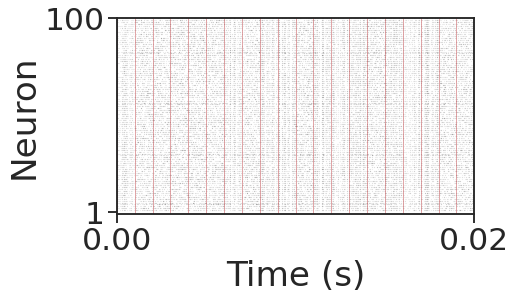

In [ ]:
# Define number of neurons, trial times, fraction of correct trials, correlations in the two latent states, etc.
Num_neurons = 100 # Number of neurons.
Num_trials = 20
taujitter = 5 # Jitter spike trains to avoid perfect synchrony.
# Define baseline and elevated pairwise correlations.
c_baseline = 0.01
c_elevated = 0.5
# placeholders until V1 data is available
perc_corr = 0.5
firingRate = 20/1000 # kHz
time_to_onset = 1000 # Time of each trial in ms. This is variable so we can add a random variable to jitter it.
dtRate = 10 # ms (bin size)
window = 10 #ms bin size of moving window.
# Call function to generate trials with elevated and baseline correlations.
spike_train, firing_rates, trials_correct, spike_counts = simulate_trials_different_corrs(Num_neurons, Num_trials, 
                                                                            perc_corr, firingRate,taujitter,
                                                                            c_baseline, c_elevated, 
                                                                            time_to_onset, dtRate, window)
spike_train[:,1:] = spike_train[:,1:]/1000
# Plot all neurons over the whole simulated experiment.
fig=plt.figure(figsize=(8,5))
ax = plt.subplot(111)
plot_raster_function(spike_train[:,1],spike_train[:,0],markersize=.05)

for tr in range(0,20):
    plt.axvline(x=tr/1000, color= 'r', lw= 0.5)

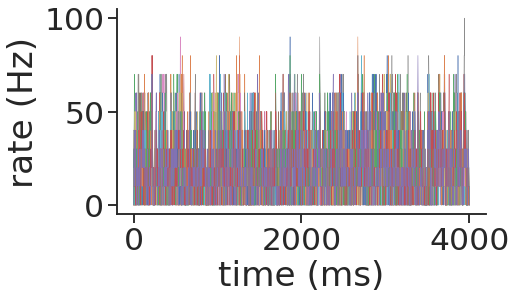

In [ ]:
## Visualize correlated firing rates.
# We have simulated the spike trains with varying firing rates on different trials.
# Now we use them to compute the firing rate of each neuron.
# Start the figure.
fig=plt.figure(figsize=(8,5))
ax = plt.subplot(111)

# Plot a few neurons over the whole experiment.
for i in range(Num_neurons//40):
  plot_firing_rates(range(len(firing_rates[i])), firing_rates[i,:],linewidth=0.5)

# If we want a legend:
# leg = plt.legend(loc='upper right',fontsize=18,frameon='none',markerscale=1)
# leg.get_frame().set_linewidth(0.0)

## Generate simulated data for cross validation



In [ ]:
## Comment out data not used.
# If training data was uncorrelated with baseline and elevated firing rates.
spike_train_cv, firing_rates_cv, trials_correct_cv, spike_counts_cv = simulate_trials_different_rates(Num_neurons, 
                                                                                          Num_trials, perc_corr, firingRate, 
                                                                                          rate_elevated, time_to_onset, 
                                                                                          dtRate, window)


# If training data was correlated with baseline and elevated correlations.
spike_train_cv, firing_rates_cv, trials_correct_cv, spike_counts_cv = simulate_trials_different_corrs(Num_neurons, Num_trials, 
                                                                            perc_corr, firingRate,taujitter,
                                                                            c_baseline, c_elevated, 
                                                                            time_to_onset, dtRate, window)


## Calculate & plot principal components
We next reduce the dimensionality of our data across neurons. We want to map our data onto a lower dimensional space in order to capture population-wide activity, to reduce stochastic noise introduced by each neuron, and to provide our HMM a simplified input which is more likely to be repeated in our cross-validation data than the fully complex raw data.

### PCA
Apply PCA to either dataset generated above.

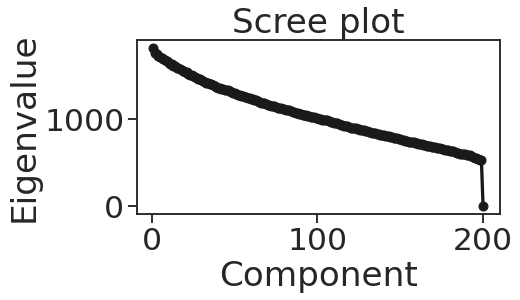

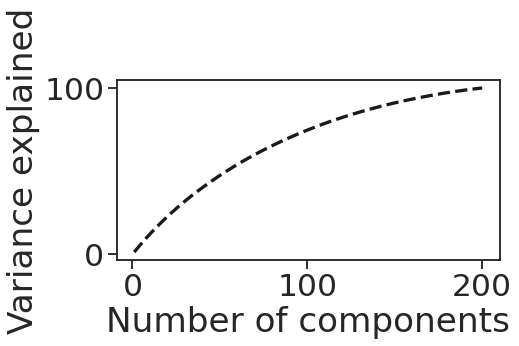

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:47: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
  result = getattr(asarray(obj), method)(*args, **kwds)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:47: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
  result = getattr(asarray(obj), method)(*args, **kwds)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:47: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
  result = getattr(asarray(obj), method)(*args, **kwds)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:47: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surp

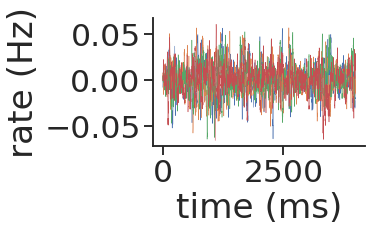

In [ ]:
#input: a matrix where each row is a neuron, each column is firing rate in a timebin
#calculate eigenvectors
pca_model = PCA(n_components=Num_neurons) #can be any number, but limiting to 20 saves computational time
pca_model.fit(firing_rates)

#scree plot
plot_eigenvalues(pca_model.singular_values_[0:Num_neurons])

#variance explained plot
variance_explained = np.cumsum(pca_model.explained_variance_ratio_)*100
plot_variance_explained(variance_explained[0:Num_neurons])

# Save first principal component.
first_component = pca_model.components_.T[:,1] # rows=samplewholeexperiment, cols=PCs
firing_rate_input_hmm = trace_to_trials_function(first_component,time_to_onset,dtRate,Num_trials)

#plot the first 5 components
for c in range(4):
  plot_firing_rates(range(len(pca_model.components_[c])),pca_model.components_[c,:],linewidth=0.5)

In [ ]:
# scale & discretize PCs into spike counts
trace = pca_model.components_[1]
trace = trace - trace.min() #make minimum 0
trace = trace/(trace.max() - trace.min()) #scale between 0 & 1
trace = trace*(spike_counts.max()*spike_counts.shape[0]) #scale between 0 & max spike counts/bin
spike_trace = int(trace) #discretize

TypeError: ignored

We observe an elbow on the scree plot at xxxx components. These xxxx first components explain xxxx% of the variance.

### Factor Analysis

In [ ]:
#FA
#calculate eigenvectors
# fa = FactorAnalyzer(n_factors=10) #determines how the data will be sliced
# fa.fit(firing_rates) #if any neurons are identical to another or are all zeros, this will throw an error

# #scree plot
# ev,_ = fa.get_eigenvalues()
# plot_eigenvalues(ev)

# #variance explained plot
# _,_,cv = fa.get_factor_variance()
# plot_variance_explained(cv*100)

# #plot the first 5 components
# for c in range(5):
#   plot_firing_rates(range(len(fa.loadings_[c].T)),fa.loadings_[:,c].T,linewidth=0.5)
#   #plot_rate(fa.loadings_[:,c].T)

We observe an elbow on the scree plot at xxxx components. These xxxx first components explain xxxx% of the variance.

## Build & examine HMM
We next take the first principal component, parcellate it into trials, and give it as input to the HMM. Our HMM takes an input array of shape (samples, features), where samples = trials and features = the dimensionally reduced neural data (the first principal component).

In [ ]:
## Old HMM code with Gaussian emissions.

# #parcellate pca_model.components_[c,:] into trials
# n = firing_rate_input_hmm # crashes if you try to run all time points
# simmodel= hmm.GMMHMM(n_components=2)
# simmodel.fit(n)
# states= simmodel.predict(n)
# print(states)
# plt.plot(states)

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

The HMM is not able to capture the latent states when trained on the first principal component only. We will try next to instead train it on the mean firing rate or the firing rate of one neuron.

**Note**: Since the EM algorithm is a gradient-based optimization method, it will generally get stuck in local optima. You should in general try to run fit with various initializations and select the highest scored model.

### Train HMM on mean firing rate of raw simulated firing rates.

In [ ]:
## Old HMM with Gaussian emissions. 
# np.random.seed(22)

# # Either use mean firing rate.
# new_fr_hmm_input = trace_to_trials_function(np.mean(firing_rates,axis=0),time_to_onset,dtRate,Num_trials)
# # Or use firing rate of one neuron.
# # new_fr_hmm_input = trace_to_trials_function(firing_rates[0],TrialTime,dtRate,Num_trials)

# # Train using spike counts.
# new_fr_hmm_input = trace_to_trials_function(np.mean(spike_counts,axis=0),time_to_onset,dtRate,Num_trials)

# n= new_fr_hmm_input.T
# simmodel= hmm.GMMHMM(n_components=2,n_iter=100)
# simmodel.fit(n)

# print(simmodel.transmat_)

# states= simmodel.predict(n)
# plt.plot(states)

Instead of using hmmlearn, we now use the ssm package from [Scott Linderman's lab](https://github.com/slinderman/ssm). We fit an HMM that takes as input a matrix of spike counts where rows=timebins and cols=neurons. 

In [ ]:
# Here we need to import all the stuff from slinderman's github.
# git clone https://github.com/slinderman/ssm/ssm.git
# cd ssm
# !pip install numpy cython
# !pip install -e .

import ssm
import tqdm
num_states = 2
num_neurons = Num_neurons

# Manually set the initial state distribution
init_dist = ssm.init_state_distns.FixedInitialStateDistribution(num_states,
                                                                num_neurons,
                                                                pi0 = np.array([1, 0]))
# Create our HMM
simple_hmm = ssm.HMM(num_states,
                     num_neurons,
                     observations="poisson",
                     transitions="standard",
                     init_state_distn=init_dist)

# Manually initialize the transition probabilities. If the transitions are not initialized well, model may overfit.
A = np.array(
[[0.5, .5],
[.5, 0.5]])
simple_hmm.transitions.log_Ps = np.log(A + 1e-16)

# # If desired, manually initialize the means for each state
firing_rate_input_hmm = trace_to_trials_function(np.sum(spike_counts,axis=0)
                                                    ,time_to_onset,dtRate,Num_trials)
firing_rate_input_hmm = firing_rate_input_hmm.astype(int)

mean_count_baseline_trials = np.zeros((100,))
mean_count_elevated_trials = np.zeros((100,))
for trial in range(Num_trials):
    if trial in trials_correct: # If trial is correct.
        mean_count_elevated_trials += firing_rate_input_hmm[:,trial]
    else:
        mean_count_baseline_trials += firing_rate_input_hmm[:,trial]
mean_count_baseline_trials = mean_count_baseline_trials/Num_trials/2
mean_count_elevated_trials = mean_count_elevated_trials/Num_trials/2
lambdas_baseline = mean_count_baseline_trials
lambdas_elevated = mean_count_elevated_trials
lambdas = np.vstack((lambdas_baseline,
                     lambdas_elevated))
simple_hmm.log_lambdas = np.log(lambdas + 1e-16)

# Define the data used: either simulated or actual data.
data = spike_counts.astype(int).T # Input has to be an array of spike counts 
# with rows=time bin (whole experiment) and cols=neurons.
print(data.shape, '= time bins x neurons')

In [ ]:
# Fit the model using the 'em' algorithm.
lls = simple_hmm.fit(data, method='em')

In [ ]:
# Calculate and plot posterior probabilities. 
posterior = simple_hmm.filter(data)

# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(10,4))
# make a plot with different y-axis using second axis object
ax.plot(spike_train[:,0]/dtRate,spike_train[:,1]+1,
         'k.',markersize=.025)
ax.set_ylabel("Neuron",color="black")
plt.ylim((0,Num_neurons))

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot
for i in range(num_states):
    ax2.plot(posterior[:,i],label="State %d" % i)
# set x-axis label
ax2.set_xlabel("Time bins")
plt.xlim((0,time_to_onset*Num_trials//dtRate))
# set y-axis label
ax2.set_ylabel("Posterior prob",color="red")
# Plot in green the mean firing rate to visualize states.
plt.plot(np.mean(firing_rates,axis=0)/rate_elevated/1000-0.25, 
         label='firing rate',linewidth=2.5,color='tab:green')

plt.show()

In [ ]:
# Calculate and plot posterior probabilities for the validation dataset.
data_cv = spike_counts_cv.T 
posterior = simple_hmm.filter(data_cv)

# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(10,4))
# make a plot with different y-axis using second axis object
ax.plot(spike_train_cv[:,0]/dtRate,spike_train_cv[:,1]+1,
         'k.',markersize=.025)
ax.set_ylabel("Neuron",color="black")
plt.ylim((0,Num_neurons))

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot
for i in range(num_states):
    ax2.plot(posterior[:,i],label="State %d" % i)
# set x-axis label
ax2.set_xlabel("Time bins")
plt.xlim((0,time_to_onset*Num_trials//dtRate))
# set y-axis label
ax2.set_ylabel("Posterior prob",color="red")
# Plot in green the mean firing rate to visualize states.
plt.plot(np.mean(firing_rates_cv,axis=0)/rate_elevated/1000-0.25, 
         label='firing rate',linewidth=2.5,color='tab:green')

plt.show()

The HMM is fits the training data very well. It remains to test it on the validation dataset.

Percent correct & state transition plot

In [ ]:
obs_label = "Ground Truth"
title = "Simulated correct/incorrect trials"
plot_states(real_states, states, obs_label, title)

per_correct, states = get_accuracy(real_states, states)
print('Percent correctly classified:',per_correct,'%')

print(simmodel.start_prob_)
print(simmmodel.transmat_)

Cross-validation

In [ ]:
## Compute PCA of cv data. ##
#input: a matrix where each row is a neuron, each column is firing rate in a timebin
#calculate eigenvectors
pca_model_cv = PCA(n_components=Num_neurons) #can be any number, but limiting to 20 saves computational time
pca_model_cv.fit(firing_rates_cv)
#scree plot
plot_eigenvalues(pca_model_cv.singular_values_[0:Num_neurons])
#variance explained plot
variance_explained_cv = np.cumsum(pca_model_cv.explained_variance_ratio_)*100
plot_variance_explained(variance_explained_cv[0:Num_neurons])
# Save first principal component.
first_component_cv = pca_model.components_.T[:,1] # rows=samplewholeexperiment, cols=PCs
firing_rate_input_hmm_cv = trace_to_trials_function(first_component_cv,TrialTime,dtRate,Num_trials)

In [ ]:
#extract principal component
pca_model_cv = PCA(n_components=20) #can be any number, but limiting to 20 saves computational time
pca_model_cv.fit(firing_rates_cv)

#parcellate pca_model.components_[c,:] into trials

#use previously built model to predict states on cross-validation data
n_cv = pca_model.components_[:19,:100] # crashes if you try to run all time points
states_cv = simmodel.predict(n_cv)

#calculate how well our model fit the held-out data
obs_label = "CV Ground Truth"
title = "Cross-validation simulated data"
plot_states(real_states_cv, states_cv, obs_label, title)

per_correct_cv, states_cv = get_accuracy(real_states_cv, states_cv)
print('Cross-validation accuracy:',per_correct_cv,'%')

print(simmodel.start_prob_)
print(simmmodel.transmat_)

How to create an HMM with binary state variables (simple)

In [ ]:
def create_model():
    """
    Create an HMM with binary state variable and 1D Gaussian observations
    The probability to switch to the other state is 1. Two observation models have 
    mean 1.0 and -1.0 respectively and almost zero standard deviation

    Returns:
        model (hmm.GaussianHMM instance): the described HMM
    """
    n_components = 2
    model = hmm.GaussianHMM(n_components=n_components, covariance_type="full")
    model.startprob_ = np.array([1.0, 0.0])
    model.transmat_ = np.array([[0.0, 1.0],[1.0, 0.0]])
    model.means_ = np.array([[1.0],[-1.0]])
    model.covars_ = np.tile(np.eye(1) * 1e-8 , (2, 1, 1))
    model.sample(1)
    return model


nstep = 15
model = create_model()
observations, states = model.sample(nstep)
observations = observations.flatten()

table = pd.DataFrame({"states": states,"observations":observations})
print(table)

with plt.xkcd():
    plot_hmm1(model, states, observations)


    states  observations
0        0      0.999960
1        1     -1.000050
2        0      1.000032
3        1     -1.000015
4        0      0.999816
5        1     -0.999915
6        0      0.999964
7        1     -0.999841
8        0      1.000263
9        1     -1.000135
10       0      0.999996
11       1     -0.999970
12       0      1.000069
13       1     -0.999989
14       0      0.999959


NameError: ignored

How to create HMM with binary state variables (complex)

In [ ]:
def my_create_model(switch_prob=0.1,noise_level=0.5):
    """
    Create an HMM with binary state variable and 1D Gaussian observations
    The probability to switch to the other state is `switch_prob`. Two observation models have 
    mean 1.0 and -1.0 respectively. `noise_level` specifies the standard deviation of the observation
    models.

    Args:
        switch_prob (float): probability to jump to the other state
        noise_level (float): standard deviation of observation models. Same for two components
    Returns:
        model (hmm.GaussianHMM instance): the described HMM
    """
    n_components = 2
    model = hmm.GaussianHMM(n_components=n_components, covariance_type="full")
    model.startprob_ = np.array([1.0, 0.0])
    model.transmat_ = np.array([[1.0-switch_prob, switch_prob],
                                [switch_prob, 1.0-switch_prob]])
    model.means_ = np.array([[1.0],[-1.0]])
    model.covars_ = np.tile(np.eye(1) *np.power(noise_level,2)  , (2, 1, 1))
    model.sample(1)
    return model

nstep = 100
model = my_create_model()
observations, states = model.sample(nstep)
observations = observations.reshape(-1)

table = pd.DataFrame({"states": states,"observations":observations})
print(table)

with plt.xkcd():
  plot_hmm1(model, states, observations)



**Poisson Spiking Neural Network**

Model and simulation parameters

In [ ]:
# model and data parameters
C = 5  # number of cells
K = 3  # number of states
dt = 0.002  # seconds
trial_T = 2.0  # seconds
n_frozen_trials = 20  # used to plot multiple trials with the same state sequence
n_trials = 300  # number of trials (each has it's own state sequence)

# for random data
max_firing_rate = 50  # Hz
max_transition_rate = 3  # Hz

# needed to plot LL and ECLL for every M-step
# **This substantially slows things down!!**
num_plot_vals = 10  # resolution of the plot (this is the expensive part)
b_lims = (-1, 2)  # lower limit on graph (b = 0 is start-of-M-step LL; b = 1 is end-of-M-step LL)
plot_epochs = list(range(9))  # list of epochs to plot

Initialize true model

In [ ]:
np.random.seed(9)
T = round(trial_T / dt)
ts = np.arange(T)

# initial state distribution
psi = np.arange(1, K + 1)
psi = psi / psi.sum()

# off-diagonal transition rates sampled uniformly
A = np.random.rand(K, K) * max_transition_rate * dt
A = (1 - np.eye(K)) * A
A = A + np.diag(1 - A.sum(1))

# hand-crafted firing rates make good plots
L = np.array([
    [.02, .8, .37],
    [1., .7, .1],
    [.92, .07, .5],
    [.25, .42, .75],
    [.15, .2, .85]
]) * max_firing_rate     # (C,K)

# Save true parameters for comparison later
psi_true = psi
A_true = A
L_true = L

Generate data with frozen sequence and plot

In [ ]:
Xf = np.zeros(T, dtype=int)
Xf[0] = (psi.cumsum() > np.random.rand()).argmax()
for t in range(1, T):
    Xf[t] = (A[Xf[t - 1],:].cumsum() > np.random.rand()).argmax()

# switch to one-hot encoding of the state
Xf = np.eye(K, dtype=int)[Xf]  # (T,K)

# get the Y values
Rates = np.squeeze(L @ Xf[...,None]) * dt  # (T,C)
Rates = np.tile(Rates, [n_frozen_trials,1,1]) # (n_trials, T, C)
Yf = ss.poisson(Rates).rvs()

## Background color indicates state
plot_spike_train(Xf, Yf, dt)

In [ ]:
#code for state transition plot over trials with an overlay of the correct/incorrect transitions goes here

#code for % correct: HMM state vs correct/incorrect
#binary classifier which takes HMM state as an input and predicts correct/incorrect as an output goes here

Our HMM posterior probability over states visually matches the transitions between correct and incorrect trials, and the state transitions explain much of the variance of the trial performance. So our model was successful in recovering some structure related to task performance in simulated data. Next, we will try to find this same structure in real data.

## Apply GPFA to simulated data
We have simulated two sets of data: (1) network with up and down states of firing rate, (2) network with lower and higher correlations states. The up and down states of firing rates or correlations can be interpreted as correct and incorrect trials, respectively.


Initializing parameters using factor analysis...

Fitting GPFA model...


/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.canvas.print_figure(bytes_io, **kw)


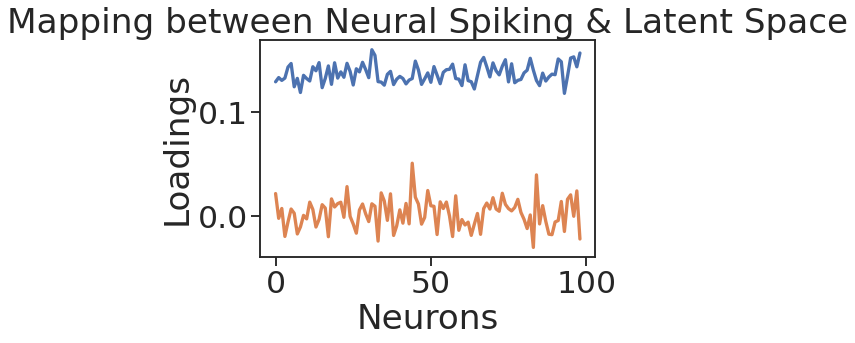

In [ ]:
# Build the spike train structure needed.
spike_times = build_spike_train(spike_train)

# fit GPFA
gpfa_2dim = GPFA(bin_size=10*pq.ms, x_dim=2)
gpfa_2dim.fit(spike_times)

# plot loadings of the 2 dimensions
plt.plot(gpfa_2dim.params_estimated['C'])
plt.xlabel('Neurons')
plt.ylabel('Loadings')
plt.title('Mapping between Neural Spiking & Latent Space')
plt.show()

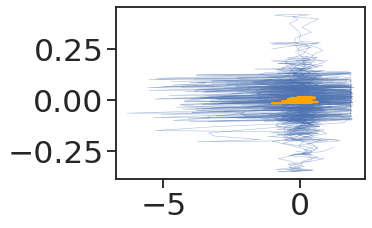

In [ ]:
## Plot the single trial trajectories in latent space.

trajectories = gpfa_2dim.transform(spike_times)
# contralateral_behavior = contralateral_behavior.T
# print(contralateral_behavior[0:5,:])
# plt.plot(trial_starts)
# plt.plot(contralateral_behavior[contralateral_behavior[:,1]==1,0])
# print(len(contralateral_behavior[contralateral_behavior[:,1]==1,1]))
# print(len(sorted(set(v1_spikes_data[:,2]))))
# print(len(contralateral_behavior[:,1]))

# single trial trajectories
for single_trial_trajectory in trajectories:
  plt.plot(single_trial_trajectory[0], single_trial_trajectory[1], '-', lw=0.5, c='b', alpha=0.5) #TODO: color code based on trial type
# trial averaged trajectory
average_trajectory = np.mean(trajectories, axis=0) #TODO: change mean to handle diff lengths
plt.plot(average_trajectory[0], average_trajectory[1], '-', lw=2, c='orange', label='Trial averaged trajectory')

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   16.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   23.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   30.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   33.6s finished


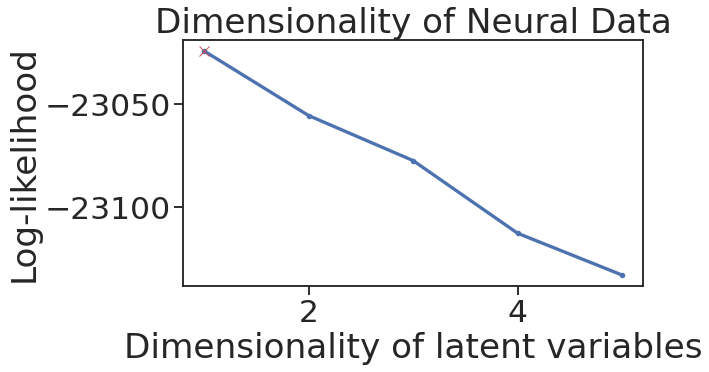

In [ ]:
## Find the dimensionality of our data. Compute log likelihood for different values of x_dim.
from sklearn.model_selection import cross_val_score

x_dims = [1, 2, 3, 4, 5]
log_likelihoods = []
for x_dim in x_dims:
  gpfa_cv = GPFA(x_dim=x_dim)
  # estimate the log-likelihood for the given dimensionality as the mean of the log-likelihoods from 3 cross-vailidation folds
  cv_log_likelihoods = cross_val_score(gpfa_cv, spike_times, cv=3, n_jobs=3, verbose=True)
  log_likelihoods.append(np.mean(cv_log_likelihoods))

f = plt.figure(figsize=(10, 6))
plt.xlabel('Dimensionality of latent variables')
plt.ylabel('Log-likelihood')
plt.plot(x_dims, log_likelihoods, '.-')
plt.plot(x_dims[np.argmax(log_likelihoods)], np.max(log_likelihoods), 'x', markersize=10, color='r')
plt.title('Dimensionality of Neural Data')
plt.show()

# Build a model using real data from V1

## Extract neural and behavioral data from full dataset
Here, we focused on data from trials where the higher contrast stimulus was presented on the contralateral side (right side). We isolated units from clusters whose peak amplitude was on channels in V1. We selected only neural firing during the period between stimulus presentation and the go cue.

In [ ]:
## upload matrix for PCA into colab, from github
url = 'https://raw.githubusercontent.com/emilyasterjones/NMA2020-Seals-Evading-Hidden-States/master/matrix_for_pca.txt'
url2 = 'https://raw.githubusercontent.com/emilyasterjones/NMA2020-Seals-Evading-Hidden-States/master/ipsilateral_for_pca.txt'
v1_spikes_data = np.loadtxt(url)
ipsi_spike_data = np.loadtxt(url2)
# datasets are now stored in a numpy matrix
# five columns: neuron IDs, timestamps, trial start time, trial end time, behavior (1 is correct, 0 incorrect)

In [ ]:
# get session IDs & start times
session = np.diff(v1_spikes_data[:,2]) < 0
session = np.cumsum(session)
session = np.append(session, session[-1])
sess_start_idx = np.where(np.diff(v1_spikes_data[:,2]) < 0)
sess_start_idx = tuple(x+1 for x in sess_start_idx) #avoid off by 1 error
sess_start_idx = np.insert(sess_start_idx, 0, 0) #first trial in first session
sess_start_times = v1_spikes_data[sess_start_idx,2]

# get trial IDs & start times
trial = np.diff(v1_spikes_data[:,2]) != 0
trial = np.cumsum(trial)
trial = np.append(trial, trial[-1])
trial_start_idx = np.where(np.diff(v1_spikes_data[:,2]) != 0)
trial_start_idx = tuple(x+1 for x in trial_start_idx) #avoid off by 1 error
trial_start_idx = np.insert(trial_start_idx, 0, 0) #first trial in first session
trial_start_times = v1_spikes_data[trial_start_idx,2]
trial_end_times = v1_spikes_data[trial_start_idx,3]

# shift timestamps to make 1 continuous trace
spike_train = v1_spikes_data[:,1]
Num_trials = len(trial_start_times)
# shift spike times back to end of last trial interval
for t in range(1, Num_trials):
  trial_spikes = np.where(trial==t) #get first spike in trial
  spike_train[trial_spikes[0][0]:] -= trial_end_times[t-1] - trial_start_times[t]
# shift spike times back to start of session
spike_train -= sess_start_times[session]

Num_sess = len(sess_start_times)
bin = 10 #ms
for s in range(Num_sess):
  sess_range = np.arange(sess_start_idx[s],sess_start_idx[s+1])
  spike_counts, firing_rates = bin_spikes(v1_spikes_data[sess_range,0], spike_train[sess_range],
                                          v1_spikes_data[sess_range[-1],3], bin)
  #iterate over trials in a session
  for t in range(len(set(trial[sess_range]))):
    trial_range = np.arange(trial_start_idx[t],trial_start_idx[t+1])
    sc, _ = bin_spikes(v1_spikes_data[trial_range,0], spike_train[trial_range],
                                          trial_end_times[t], bin)
    if t==0:
      spike_count_trial_starts = []
      spike_count_trial_starts.append(0)
    else: #add length of this trial to the vector of trial lengths
      spike_count_trial_starts.append(len(sc))

ValueError: ignored

In [ ]:
# data for GPFA
# url3 = 'https://raw.githubusercontent.com/emilyasterjones/NMA2020-Seals-Evading-Hidden-States/master/contralateral_behavior.txt'
# url4 = 'https://raw.githubusercontent.com/emilyasterjones/NMA2020-Seals-Evading-Hidden-States/master/ipsilateral_behavior.txt'
# contralateral_behavior = np.loadtxt(url3)
# ipsilateral_behavior = np.loadtxt(url4)

## Extract first principal component
To reduce dimensionality of our neural spiking traces, we then binned into 10ms time bins, concatenated all data for each neuron into a single trace, and calculated the first principal component of the data across all neurons.

## GPFA

### Build model

/usr/local/lib/python3.6/dist-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/usr/local/lib/python3.6/dist-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/usr/local/lib/python3.6/dist-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/usr/local/lib/python3.6/dist-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/usr/local/lib/python3.6/dist-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/usr/local/lib/python3.6/dist-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
 

Initializing parameters using factor analysis...

Fitting GPFA model...


/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.canvas.print_figure(bytes_io, **kw)


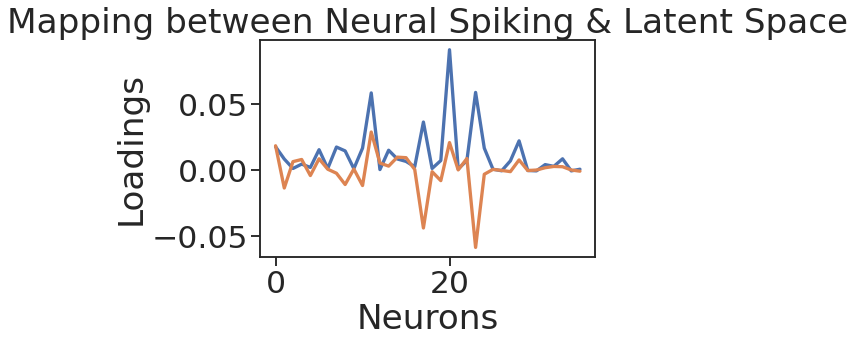

In [ ]:
#get the first session
session = np.diff(v1_spikes_data[:,2]) < 0
session = np.cumsum(session)
session = np.append(session, session[-1])
v1_spikes_data_sess1 = v1_spikes_data[session==3,:]

spike_times = build_spike_train(v1_spikes_data_sess1)

# fit GPFA
gpfa_2dim = GPFA(bin_size=10*pq.ms, x_dim=3)
gpfa_2dim.fit(spike_times)

# plot loadings of the 2 dimensions
plt.plot(gpfa_2dim.params_estimated['C'])
plt.xlabel('Neurons')
plt.ylabel('Loadings')
plt.title('Mapping between Neural Spiking & Latent Space')
plt.show()

### Plot trajectories

/usr/local/lib/python3.6/dist-packages/elephant/conversion.py:463: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/usr/local/lib/python3.6/dist-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/usr/local/lib/python3.6/dist-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/usr/local/lib/python3.6/dist-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/usr/local/lib/python3.6/dist-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
/usr/local/lib/python3.6/dist-packages/elephant/conversion.py:463: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
 

(-1.0, 1.0)

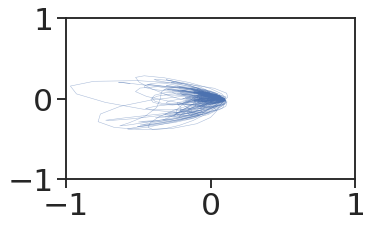

In [ ]:
trajectories = gpfa_2dim.transform(spike_times)
correct = np.array(correct)
c_ind = np.where(correct==1)
ic_ind = np.where(correct==0)
colors = ['r','b']

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for t, single_trial_trajectory in enumerate(trajectories):
  ax.plot(single_trial_trajectory[0], single_trial_trajectory[1], single_trial_trajectory[2], lw=1, c=colors[correct[t]], alpha=0.5)
ax.set_xlabel('Dim 1')
ax.set_ylabel('Dim 2')
ax.set_zlabel('Dim 3')
custom_lines = [Line2D([0], [0], color='b', lw=2),
                Line2D([0], [0], color='r', lw=2)]
ax.legend(custom_lines, ['Correct', 'Incorrect'])
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
t = c_ind[0][0]
single_trial_trajectory = trajectories[t]
ax.plot(single_trial_trajectory[0], single_trial_trajectory[1], single_trial_trajectory[2], lw=0.5, c=colors[correct[t]], alpha=0.5)
t = ic_ind[0][0]
single_trial_trajectory = trajectories[t]
ax.plot(single_trial_trajectory[0], single_trial_trajectory[1], single_trial_trajectory[2], lw=0.5, c=colors[correct[t]], alpha=0.5)
ax.set_xlabel('Dim 1')
ax.set_ylabel('Dim 2')
ax.set_zlabel('Dim 3')
plt.show()

In [ ]:
# print an example correct/incorrect trajectory
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title(f'Trajectory for correct trial')
ax1.set_xlabel('Time [s]')
times_trajectory = np.arange(len(trajectories[c_ind[0][0]][0])) * bin_size.rescale('s')
ax1.plot(times_trajectory, trajectories[c_ind[0][0]][0], label="Dim 1")
ax1.plot(times_trajectory, trajectories[c_ind[0][0]][1], label="Dim 2")
ax1.plot(times_trajectory, trajectories[c_ind[0][0]][2], label="Dim 3")
ax1.set_ylim(-2.75, 0.5)
ax1.legend()

ax2.set_title(f'Trajectory for incorrect trial')
ax2.set_xlabel('Time [s]')
times_trajectory = np.arange(len(trajectories[ic_ind[0][0]][0])) * bin_size.rescale('s')
ax2.plot(times_trajectory, trajectories[ic_ind[0][0]][0], label="Dim 1")
ax2.plot(times_trajectory, trajectories[ic_ind[0][0]][1], label="Dim 2")
ax2.plot(times_trajectory, trajectories[ic_ind[0][0]][2], label="Dim 3")
ax2.legend()

plt.tight_layout()
plt.show()

### Find dimensionality

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   23.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   24.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   31.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   35.7s finished


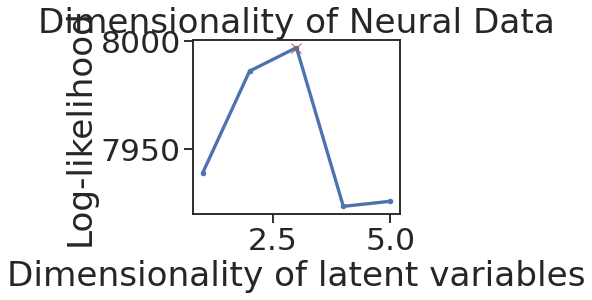

In [ ]:
#find the dimensionality of our data
from sklearn.model_selection import cross_val_score

x_dims = [1, 2, 3, 4, 5]
log_likelihoods = []
for x_dim in x_dims:
  gpfa_cv = GPFA(x_dim=x_dim)
  # estimate the log-likelihood for the given dimensionality as the mean of the log-likelihoods from 3 cross-vailidation folds
  cv_log_likelihoods = cross_val_score(gpfa_cv, spike_times, cv=3, n_jobs=3, verbose=True)
  log_likelihoods.append(np.mean(cv_log_likelihoods))

f = plt.figure(figsize=(7, 5))
plt.xlabel('Dimensionality of latent variables')
plt.ylabel('Log-likelihood')
plt.plot(x_dims, log_likelihoods, '.-')
plt.plot(x_dims[np.argmax(log_likelihoods)], np.max(log_likelihoods), 'x', markersize=10, color='r')
plt.title('Dimensionality of Neural Data')
plt.show()

## Build HMM
We then built a 2-state HMM using this first principal component as input, with the goal of extracting latent states which explain variance in behavior.

## Evaluate model performance

### Percent correct classification of performance

### Cross-validation with ipsilateral trials

# Extensions (if time allows)

## Generalization across different datasets

### Accuracy of model in integration brain regions

### Accuracy of model using inter-trial interval

## Extension to other behavioral variables

### Logistic regression: predicting latent state from reaction time

### Comparison to other relevant behavioral variables: predicting latent state from pupil diameter

# References
[Dataset: Steinmetz et al, 2019](https://www.nature.com/articles/s41586-019-1787-x)

[Review article which informed our dimensionality reduction methods](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4433019/)

Poisson HMM [demo](https://github.com/slinderman/ssm/blob/master/notebooks/Poisson%20HMM%20Demo.ipynb) 

Gaussian Process Factor Analysis [article](https://users.ece.cmu.edu/~byronyu/papers/YuJNP2009.pdf) and [demo](https://elephant.readthedocs.io/en/latest/tutorials/gpfa.html)

In [ ]:
from google.colab import drive
drive_path = '/content/gdrive'
drive.mount(drive_path)
4/2AERiDG9KXqet8AinqYJ7JNMo2S1BaD-0TQpDlGCVP_yxhCmXD72JS4

SyntaxError: ignored